# Exploratory Data Analysis
This dataset contains EEG recordings of 22 pediatric subjects with intractable seizures. In all, the onsets and ends of 182 seizures are annotated. Due to the nature of this data, I will create binary classification models that predict whether or not a patient is having a seizure.

There are many hours of EEG data within this dataset. This may seem like a lot of data on which to train, but at the same time, the target classes will be HEAVILY skewed towards 0 (no seizure). This is a problem known as **Class Imbalance** and can lead to creating biased models.

### Goals for EDA
- Graph/plot a snippet of an EEG recording
- Convert an EEG recording to a spectrogram. relearn digital signal processing techniques and gain comfort/familiarity with manipulating the data
- Bandpass filter the data. Learn domain-specific knowledge on which frequencies to bandpass/keep.
- Create a list of features that can be extracted from the data. Understand the features.
- Decide what features to use for a model

After doing some basic EDA I have decided a path forward for the project to make it consise and simple
1. I will find the patient who experienced the most seizures
   1. `chb12` had most seizures... but I will use **`chb15` as my chosen patient** since they have the most time overall in an ictal state.
3. Use that patient to wrap up EDA, gain comfort with the data
4. extract relevant features using only that patient's dataset
5. validate a data extraction pipeline proof of concept
6. train an SVM model on just that one patient
 

In [1]:
import warnings
import mne
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from extraction.tools import get_all_seizures, get_seizure_path

### Basic Analysis
- Sampling rate: 256Hz
- highest frequency we'll see is 128 bc that's half of the sampling rate... see nyquist's theorem
- Channels: 23 (i.e. the recording method had 23 sensors)
- Total Recordings: 686
- Recordings with at least 1 seizure: 142
- Total Recording Time: 982.94 Hours
- Total Seizure Time: 11,611 sec
- Ictal time compared to toal time: 0.3281%
- patient `chb12` had the most individual seizures
- patient `chb15` had the most time in seizure (ictal)


In [2]:
# count total recordings
records_file = '../data/RECORDS'
records = list()
with open(records_file, 'r') as file:
    for line in file:
        records.append(line.strip())
print(f'Total Recordings: {len(records)}')

# count total seizures
seizure_records_file = '../data/RECORDS-WITH-SEIZURES'
count = 0
with open(seizure_records_file, 'r') as file:
    for line in file:
        count += 1
print(f'Recordings with at least 1 seizure: {count}')

Total Recordings: 686
Recordings with at least 1 seizure: 141


In [3]:
# Get total time overall
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    total_time = 0
    for record in records:
        raw = mne.io.read_raw_edf(f'../data/{record}', verbose=False)
        duration = raw.n_times / raw.info['sfreq']  # total_samples / Hz => total_samples / samples_per_second => seconds
        total_time += duration
    print(f'Total Recording Time: {total_time/60/60:.2f} Hours')
    
# get total seizure time
# NOTE: this is assuming you have parsed all summary files... see extraction/parse_summaries.py
seizure_time = 0
seizures = get_all_seizures()
for seizure in seizures:
    seizure_time += seizure["end"] - seizure["start"]

print(f'Total Seizure Time: {seizure_time:,.0f} sec')
print(f'% of time that is Seizure: {(seizure_time/total_time)*100:.4f}%')

Total Recording Time: 982.94 Hours
Total Seizure Time: 11,611 sec
% of time that is Seizure: 0.3281%


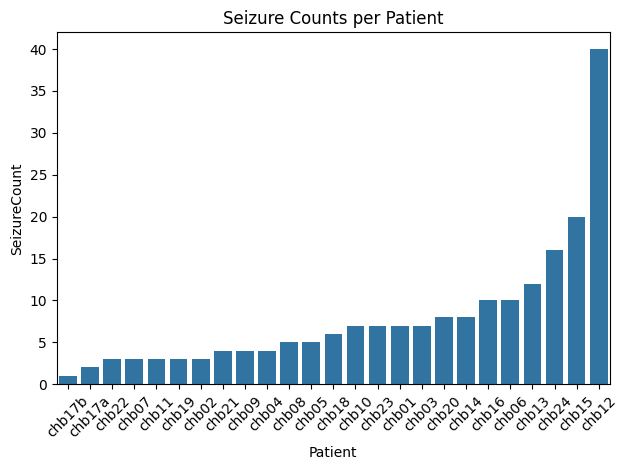

In [4]:
# bar plot comparing patients and the number of seizures they experienced
patients = dict()

for seizure in seizures:
    patient_id = seizure["file_name"].split("_")[0]
    if patient_id not in patients.keys():
        patients[patient_id] = 0

    patients[patient_id] += 1

# Convert to DataFrame
df = pd.DataFrame(list(patients.items()), columns=['Patient', 'SeizureCount'])
df = df.sort_values(by='SeizureCount', ascending=True)
# Plot
sns.barplot(data=df, x='Patient', y='SeizureCount')
plt.title('Seizure Counts per Patient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

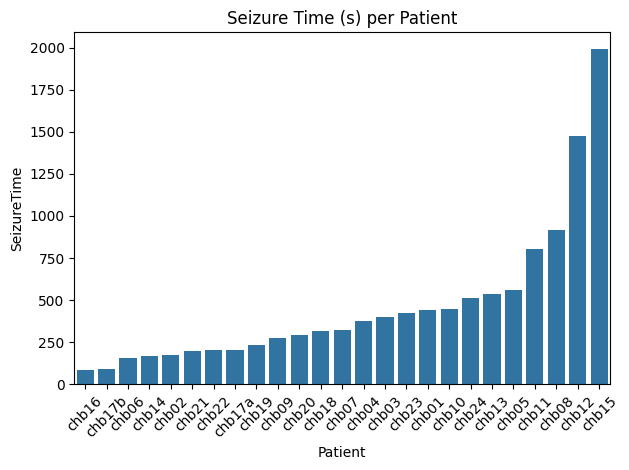

In [15]:
# bar graph showing seizure time per patient

patients = dict()

for seizure in seizures:
    patient_id = seizure["file_name"].split("_")[0]
    if patient_id not in patients.keys():
        patients[patient_id] = 0

    patients[patient_id] += seizure["end"] - seizure["start"]

df = pd.DataFrame(list(patients.items()), columns=['Patient', 'SeizureTime'])
df = df.sort_values(by='SeizureTime', ascending=True)
# Plot
sns.barplot(data=df, x='Patient', y='SeizureTime')
plt.title('Seizure Time (s) per Patient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Basic Plotting
- interesting to note in the psd plot, all the noise, the most apparent are the spikes in the data,

e.g. there is a spike at 60Hz. a well known artifact in EEG and other bioelectrical signals, it is known as **power line interference**

In [22]:
# grab a random seizure adjust its data
raw = mne.io.read_raw_edf('../data/chb15/chb15_06.edf', preload=True)
# chb 15 seems to have dead channels that we're gonna drop
raw.drop_channels(['--0', '--1', '--2', '--3', '--4', '--5'])


Extracting EDF parameters from /home/kimbo/github-repos/chb-mit-scalp-eeg/data/chb15/chb15_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_1216901/3422614377.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'-', 'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('../data/chb15/chb15_06.edf', preload=True)
/tmp/ipykernel_1216901/3422614377.py:2: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4, --5
  raw = mne.io.read_raw_edf('../data/chb15/chb15_06.edf', preload=True)


<RawEDF | chb15_06.edf, 32 x 921600 (3600.0 s), ~225.0 MiB, data loaded>

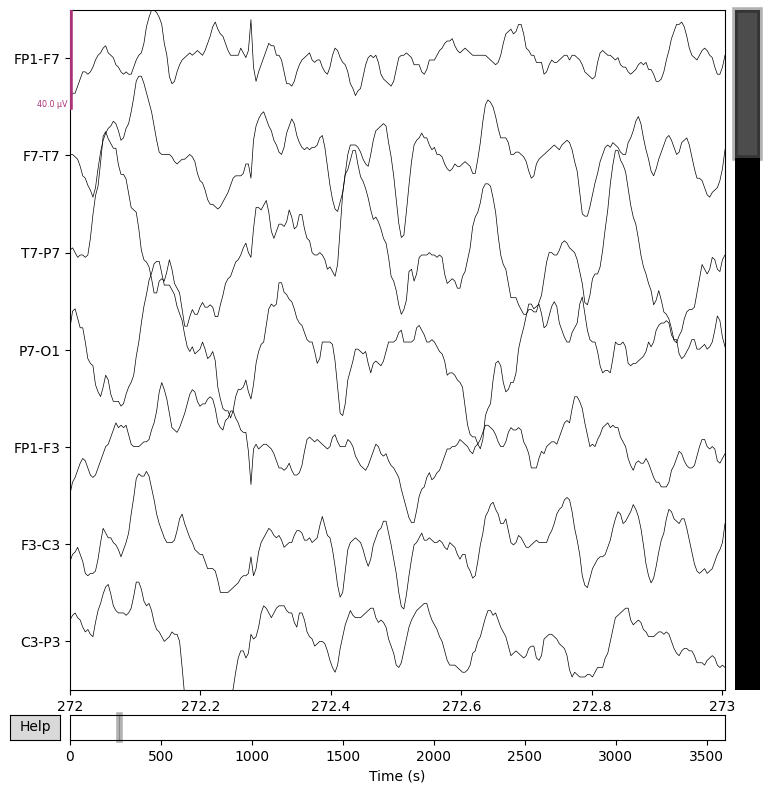

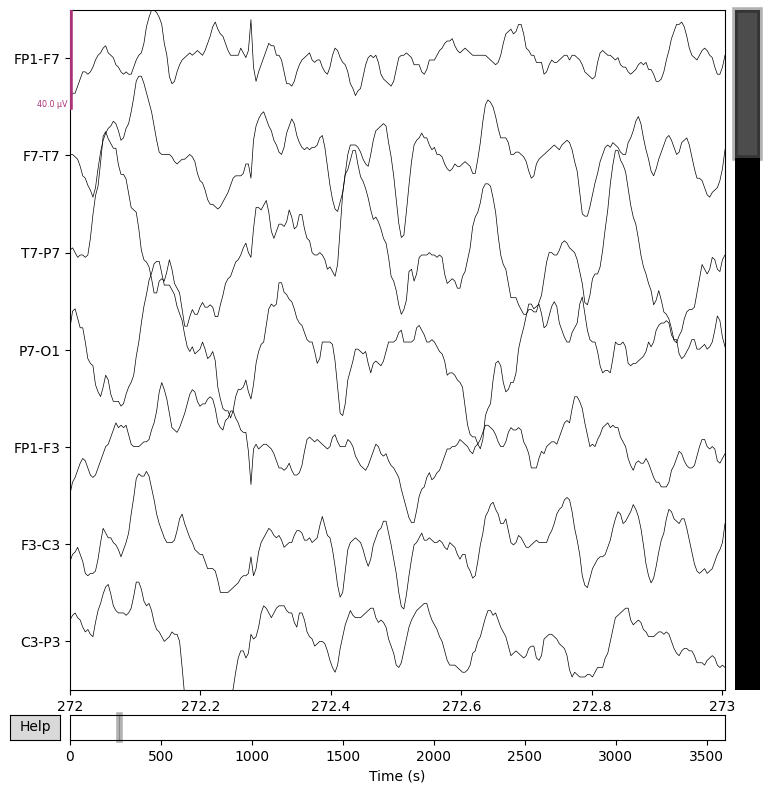

In [19]:
# plot eeg
raw.plot(start=seizures[0]["start"], duration=1, n_channels=7)        # 1 second of data from a few channels

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_1216901/2229079195.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=128).plot()


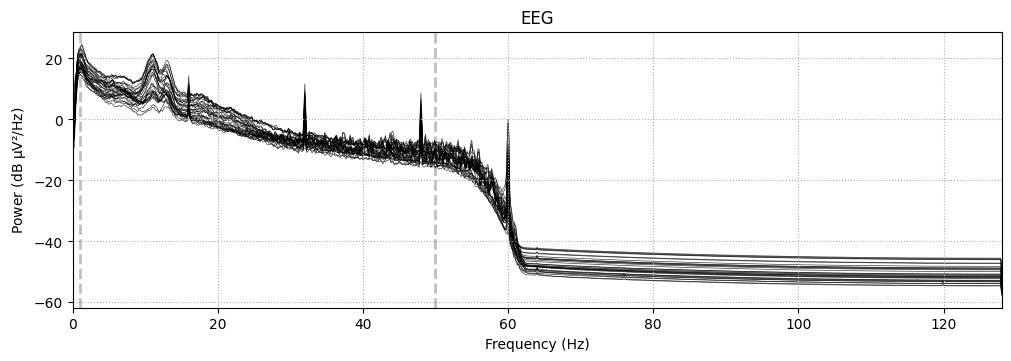

In [23]:
# Plot a PSD graph AT ONLY SEIZURE TIME to see where power is localized
start_time = seizures[0]["start"]
duration = seizures[0]["end"] - seizures[0]["start"]

# Get the data for the specified interval
raw_segment = raw.copy().crop(tmin=start_time, tmax=start_time + duration)

# apply band pass filter from 1-50Hz to get only desired data range
raw.filter(l_freq=1, h_freq=50)

raw.compute_psd(fmax=128).plot()

### Channel Constants

I found out that channels are bipolar, meaning each channel is actually a difference in voltage between two eeg electrodes


In [ ]:
frontal_channels = [
    'FP1-F7', 'FP1-F3', 'FP2-F4', 'FP2-F8',
    'F3-C3', 'F4-C4', 'FZ-CZ'
]
temporal_channels = [
    'F7-T7', 'F8-T8', 'T7-P7', 'T7-FT9', 'FT9-FT10', 'FT10-T8',
    'T8-P8-0', 'T8-P8-1', 'P7-T7'
]
occipital_channels = [
    'P3-O1', 'P4-O2', 'P7-O1', 'P8-O2', 'PZ-OZ'
]
central_parietal_channels = [
    'C3-P3', 'C4-P4', 'CZ-PZ',
    'CP1-Ref', 'CP2-Ref', 'CP5-Ref', 'CP6-Ref'
]